In [134]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

import sys
sys.path.insert(0, "..")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['diff', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [135]:
!pip3 install pysptk

In [136]:
!pip3 install pyworld

In [4]:
from os.path import join, basename

In [137]:
import torch

from scipy.io import wavfile
import pysptk
from pysptk.synthesis import Synthesizer, MLSADF
import pyworld
from os.path import join, basename

#from nnmnkwii import preprocessing as P
#from nnmnkwii.paramgen import unit_variance_mlpg_matrix

#import gantts
#from hparams import vc as hp

import librosa
import librosa.display
import IPython
from IPython.display import Audio

In [138]:
#name = "4.wav"

#original = "/content/data/org/"
#algan_vc = "/content/data/algan_vc"
#cyclegan_vc="/content/data/cyclegan_vc"
#cyclegan_vc2="/content/data/cycle2/"
#spcyclegan="/content/data/spcycle/"
#algan_wo_drn="/content/data/algan_drn/"
#algan_wo_blrs="/content/data/algan_blrs/"
#algan_wo_l1="/content/data/alganl1/"
#algan_wo_l2="/content/data/alganl2/"





#src_path = join(original, name)





#src_path = join(algan_vc , name)
#tgt_path=join(cyclegan_vc, name)




#cyc2_path=join(cyclegan_vc2, name)
#sp_path=join(spcyclegan, name)
#aldrn_path=join(algan_wo_drn, name)
#alblrs_path=join(algan_wo_blrs, name)
#al1_path=join(algan_wo_l1, name)
#al2_path=join(algan_wo_l2, name)

In [139]:
import os
 
# This is my path
path1="/content/data/cycle/"
name= "1.wav"
# to store files in a list
list_cycle = []
 
# dirs=directories
for (root, dirs, file) in os.walk(path1):
    for f in file:
        print(f)
        a=join(path1, name)
        list_cycle.append(a)

1.wav


In [140]:
path="/content/data/algan_vc/"
name= "1.wav"
# to store files in a list
list_algan = []
 
# dirs=directories
for (root, dirs, file) in os.walk(path):
    for f in file:
        print(f)
        a=join(path, name)
        list_algan.append(a)

1.wav


In [141]:
list_algan

['/content/data/algan_vc/1.wav']

In [142]:
from tqdm import tnrange
fs = 16000
frame_period=5.0
hop_length = int(fs * (frame_period * 0.001))
ms_fftlen = 4096
modfs = fs / hop_length
ms_freq = np.arange(ms_fftlen//2 + 1)/ms_fftlen * modfs
ms_freq

array([0.00000000e+00, 4.88281250e-02, 9.76562500e-02, ...,
       9.99023438e+01, 9.99511719e+01, 1.00000000e+02])

In [143]:
def compute_static_features(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=5.0)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
    alpha = pysptk.util.mcepalpha(fs)
    mc = pysptk.sp2mc(spectrogram, order=24, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    return mc

In [144]:
import numpy as np




def modspec(x, n=4096, norm=None, return_phase=False):
    
    # DFT against time axis
    s_complex = np.fft.rfft(x, n=n, axis=0, norm=norm)
    assert s_complex.shape[0] == n // 2 + 1
    R, im = s_complex.real, s_complex.imag
    ms = R * R + im * im

    # TODO: this is ugly...
    if return_phase:
        return ms, np.exp(1.0j * np.angle(s_complex))
    else:
        return ms

In [145]:
def mean_modspec(files):
    mss = []
    for idx in tnrange(len(files)):
        f = files[idx] 
        mgc = compute_static_features(f)
        #print(mgc)
        #b=log(modspec(mgc, n=ms_fftlen))
        #print(b)
        #print(np.any(b<=0))

    
        #print(b)
        ms = np.log(modspec(mgc, n=ms_fftlen))
        mss.append(ms)
    return np.mean(np.array(mss), axis=(0,))

In [146]:
ms_in2out = mean_modspec(list_algan)
ms_in2out

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1 [00:00<?, ?it/s]

array([[14.67140978, 12.03518129, 12.95494297, ...,  4.81151445,
         1.1142617 ,  2.03011089],
       [14.55679565, 11.87106928, 12.83899329, ...,  4.83194351,
         1.19000807,  2.1261753 ],
       [14.1967516 , 11.3364667 , 12.47257409, ...,  4.87866977,
         1.35261683,  2.31711652],
       ...,
       [ 0.96449069,  2.65237565, -0.18847749, ...,  1.23715038,
         1.10546732, -1.00941527],
       [-0.08484046,  1.3924135 ,  0.40747003, ...,  1.42359072,
         1.41935448, -0.63301045],
       [-1.0435956 , -3.98741876,  0.57791782, ...,  1.48148901,
         1.52436832, -0.51561758]])

In [147]:
import librosa

In [148]:
def MSD(x, y):
    #log_spec_dB_const = 10.0 / math.log(10.0) * math.sqrt(2.0)
    #print(len(x))
    #print(len(y))
    diff = x - y

    print(diff)
    return math.sqrt(np.inner(diff, diff))

In [149]:
len(mean_modspec(list_algan)[1][1:3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1 [00:00<?, ?it/s]

2

In [150]:
ms_in2out = mean_modspec(list_algan)
ms_in2out_new = mean_modspec(list_cycle)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [151]:
#MSD difference



new=0
for i in range(24):
    a=ms_in2out[i, :].T
    b=ms_in2out_new [i,:].T
    diff=np.mean(np.absolute(a-b))
    diff=(np.inner(diff, diff))
    new=new+diff


math.sqrt(1/len(mean_modspec(list_algan).T))*math.sqrt(new)

#a=ms_in2out[:, :].T
#b=ms_in2out_new [:,:].T
#diff=a-b
#diff=np.absolute(np.mean(diff))
#math.sqrt(np.inner(diff, diff))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1 [00:00<?, ?it/s]

1.337351365677831

In [124]:
diff.shape

(24, 2049)

In [ ]:
a=librosa.sequence.dtw(ms_in2out[:, 0].T, ms_in2out_new[:, 0].T, 
                                                   metric=MCD)

In [100]:
import math
ms_in2out = mean_modspec(list_algan)
ms_in2out_new = mean_modspec(list_cycle)
#print(ms_in2out_new.shape)
#diff=np.absolute(ms_in2out-ms_in2out_new)
#print(diff.shape)
#print(math.sqrt(np.inner(diff,diff)))
min_cost_tot=0
for i in range(len(mean_modspec(list_algan)[1][1:3])):
    min_cost, _ = librosa.sequence.dtw(ms_in2out[:, 1:].T, ms_in2out_new[:, 1:].T, 
                                                   metric=MCD)
    min_cost_tot= min_cost_tot+np.mean(min_cost)



final=(1/math.sqrt(len(mean_modspec(list_algan)[1][:3])))*(math.sqrt(min_cost_tot))

final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

65.34070968570073

In [65]:
diff=0
for i in range(24):
    diff=diff+np.absolute(ms_in2out[:,i]-ms_in2out_new[:,i])



In [70]:
diff=log(diff)
diff

array([1.32088396, 1.30517767, 1.2965941 , ..., 1.2097004 , 1.2757321 ,
       1.37476283])

In [72]:
print((1/2049)*(math.sqrt(np.inner(diff,diff))))

0.027719779193520144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


<Figure size 2400x2400 with 0 Axes>

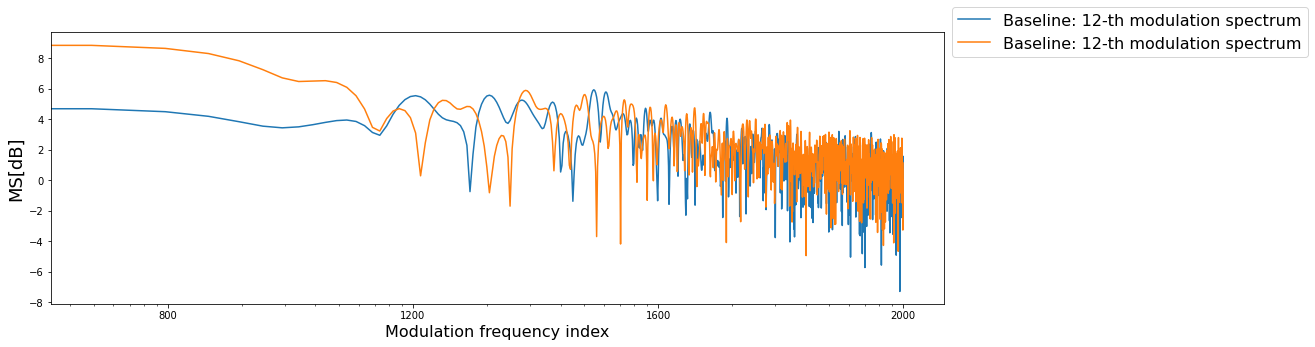

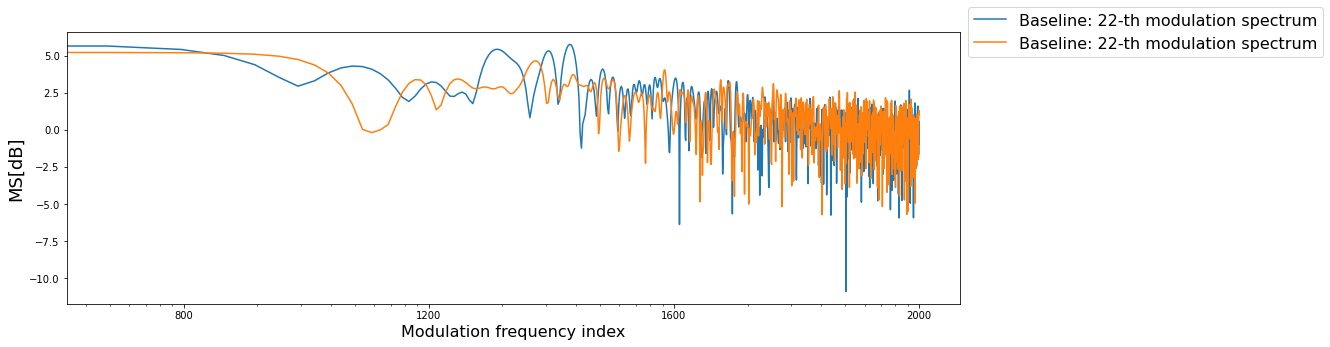

In [48]:
def vis_ms(dim=7):

    #plot(ms_freq, ms[:,dim], "-", label="Taget: {}-th modulation spectrum".format(dim))
    fig, ax = plt.subplots()
    a=ms_freq[:]
    a1=a.tolist()
    c=ms_in2out[:,dim]
    b=c.tolist()
    


    
    c_1=ms_in2out_new[:,dim]
    b_1=c_1.tolist()




    #b=c.tolist()
    values = range(len(a1))


    #print(values)
    ax.plot(a1,b,label="Baseline: {}-th modulation spectrum".format(dim))
    ax.plot(a1,b_1,label="Baseline: {}-th modulation spectrum".format(dim))
    #plt.xticks(a1,values)
    ax.set_xticks(a1,values)
    
    ax.set_xticks(a1[::50])
    xscale("log")
    xlabel("Hz", fontsize=16)
    #plt.legend(labelspacing=y, handletextpad=x,fontsize)  
    #ax.legend(prop={"size": 28})

    


    #ax.legend(loc='center left', bbox_to_anchor=(1, 1))


    plt.legend(loc='center left', prop={'size': 16}, bbox_to_anchor=(1, 1))

    #ax.legend(fontsize=16)


    #xlim(0, 100) # 50hz cutoff
    # xlim(0, 100)
    #legend(prop={"size": 18})
    ax.set_xticklabels(values[::400])
    
    #print(values)

    plt.xlabel("Modulation frequency index")
    plt.ylabel("MS[dB]",fontsize=18)
    #plt.title("Set X labels in Matplotlib Plot")
    
    plt.show()
#xticks(np.arange(0, len(b), step=25)) 


#tick_spacing = 1

#ax.plot(x,y)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plt.xticks(a1,values)



#( np.arange(0, 100, 5.0)))


#plt.xticks(np.arrange(0, 2094, 10.0))
#ax.set_xticks(np.arange(0, 2094 , 5))
#ax.set_xticks(np.arange(0, 5))
#ax.set_xticks(np.arange(0, max_number, 5))

dims = [ 12, 22]
figure(figsize=(30, 30), dpi=80)
#figure(figsize=(30, 6*len(dims)))
for idx, dim in enumerate(dims):
    #print(idx)
    #print(dim)
    #subplot(len(dims), 1, idx+1)
    vis_ms(dim)